<a href="https://colab.research.google.com/github/RachelNderitu/Deep-Learning-for-Computer-Vision/blob/main/Rachel_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Train an object detection model on a given dataset and evaluate its performance. I will compare the performance between YOLO and Faster R-CNN models trained on the dataset.**

Steps:

* Choose a dataset (e.g., COCO, PASCAL VOC, or a custom dataset).
* Select an object detection framework (e.g., Faster R-CNN, YOLO).
* Train the model and optimize hyperparameters.
* Evaluate using precision, recall, and mAP.
* Compare performance with another model.

Deliverables:

* Trained model files
* Performance evaluation report
* Comparison with at least one other object detection model

## **Step 1 : Download the COCO dataset.**

**The code below downloads and extracts the COCO 2017 validation dataset, including images and annotations, into a specified directory. This prepares the dataset for use in object detection**

In [ ]:
!mkdir -p /content/COCO
!cd /content/COCO && wget http://images.cocodataset.org/zips/train2017.zip && unzip -q train2017.zip
!cd /content/COCO && wget http://images.cocodataset.org/zips/val2017.zip && unzip -q val2017.zip
!cd /content/COCO && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip && unzip -q annotations_trainval2017.zip

--2025-02-16 18:54:28--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.192.65, 3.5.30.143, 52.216.35.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.192.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  57.2MB/s    in 5m 37s  

2025-02-16 19:00:06 (54.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-02-16 19:03:47--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.121.9, 3.5.29.129, 52.216.43.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.121.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  5

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

**The code below imports the necessary libraries for object detection using YOLO and Faster R-CNN with the COCO dataset**

In [ ]:
# Load the necessary libraries
import os
import random
import shutil
import json
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from matplotlib.patches import Rectangle
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from pycocotools.cocoeval import COCOeval
from ultralytics import YOLO
from torchvision.models.detection import fasterrcnn_resnet50_fpn

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**The code below is a preparation step to ensure the dataset directories are available before loading images for training and validation.**

In [ ]:
# Ensure dataset directories exist
train_images_dir = "/content/COCO/train2017"
val_images_dir = "/content/COCO/val2017"
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)

**The below coade loads the COCO dataset categories so they can be used for model training, evaluation, and visualization.**

In [ ]:
# Load COCO annotations
ann_file_train = "/content/COCO/annotations/instances_train2017.json"
coco = COCO(ann_file_train)
class_labels = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

loading annotations into memory...
Done (t=24.72s)
creating index...
index created!


**The code below ensures the dataset is loaded correctly and provides a quick overview of the dataset distribution before training.**


In [ ]:
# Count images
num_train_images = len([f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
num_val_images = len([f for f in os.listdir(val_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
print(f"Total Training Images: {num_train_images}")
print(f"Total Validation Images: {num_val_images}")
print("Total Categories:", len(class_labels))
print("Example Categories:", list(class_labels.values())[:10])

Total Training Images: 118287
Total Validation Images: 5000
Total Categories: 80
Example Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']


## **Step 2: Loads and runs Faster R-CNN and YOLOv8 on 100 images.**

**The code below creates a smaller dataset of 100 images for quick testing, debugging, or training a lightweight model without using the full COCO dataset**

In [ ]:
# Select 100 random images for a small dataset
small_dataset_dir = "/content/COCO/small_train2017"
os.makedirs(small_dataset_dir, exist_ok=True)
random_images = random.sample(os.listdir(train_images_dir), 100)
for img in random_images:
    shutil.copy(os.path.join(train_images_dir, img), os.path.join(small_dataset_dir, img))
print(f"100 random images copied to: {small_dataset_dir}")

100 random images copied to: /content/COCO/small_train2017


**The code below visualizes sample images from the small dataset, helping to verify that images are correctly loaded before training or further processing.**

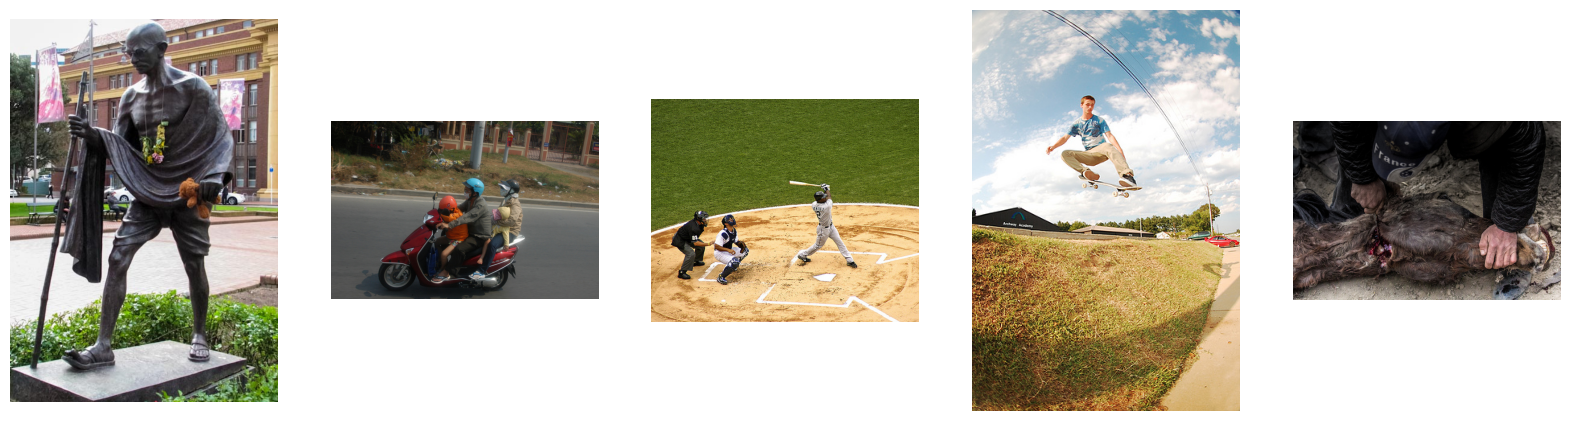

In [ ]:
# Visualize 5 random images
sample_images = random.sample(os.listdir(small_dataset_dir), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for idx, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(small_dataset_dir, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img)
    axes[idx].axis("off")
plt.show()

**The code below shows the visualizations that helps verify dataset annotations by ensuring that bounding boxes are correctly aligned with objects in the image before training the object detection model.**

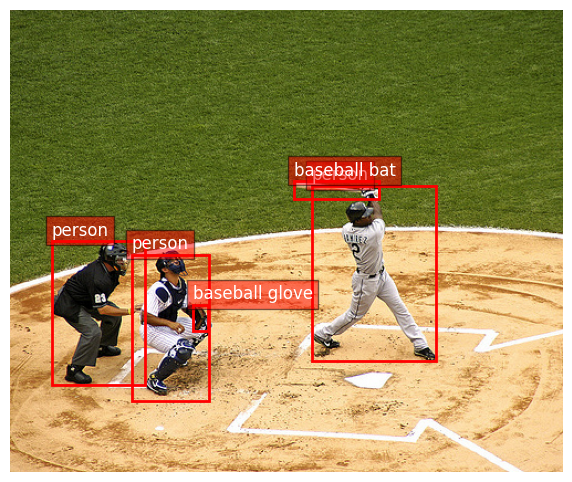

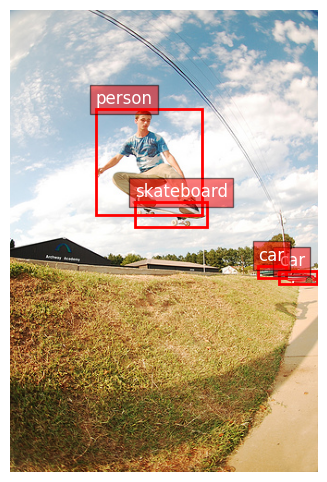

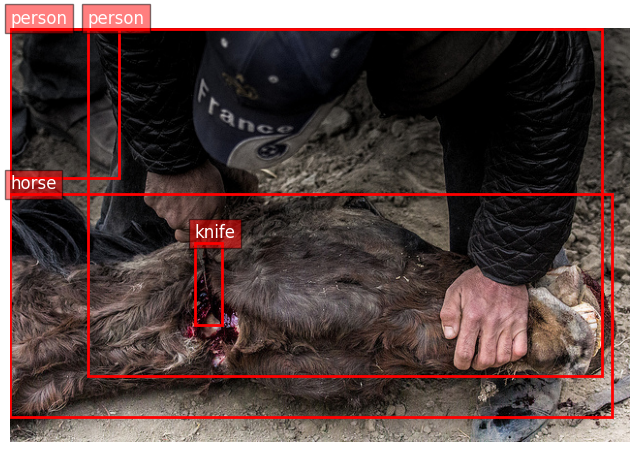

In [ ]:
# Visualize sample images with annotations
for img_name in sample_images:
    img_path = os.path.join(small_dataset_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_id = [img_info["id"] for img_info in coco.dataset["images"] if img_info["file_name"] == img_name]
    if not img_id:
        continue
    img_id = img_id[0]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    for ann in anns:
        x, y, w, h = ann["bbox"]
        category_name = class_labels.get(ann["category_id"], "Unknown")
        plt.gca().add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor="r", facecolor="none"))
        plt.text(x, y - 5, category_name, color="white", fontsize=12, bbox=dict(facecolor="red", alpha=0.5))
    plt.axis("off")
    plt.show()

### **Step 3: Load Faster R-CNN and YOLO Models**

**The code below sets up Faster R-CNN and YOLOv8 for object detection, ensuring they are ready for evaluating images. The detection results are stored for compararison.**

In [ ]:
# Load Faster R-CNN
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()

# Load YOLO model
yolo_model = YOLO("yolov8n.pt")

# Detection results storage
faster_rcnn_detections = []
yolo_detections = []

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:06<00:00, 25.9MB/s]


100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]


## **Step 4: Perform Object Detection on Random Images and saves to JSON.**

**The code below runs object detection on a sample dataset using Faster R-CNN and YOLOv8, stores results (bounding boxes, confidence scores, category IDs) for further evaluation and enables comparison between Faster R-CNN and YOLOv8 by analyzing the detection results.**
  



In [ ]:
# Perform detection
for img_name in random_images:
    image_path = os.path.join(small_dataset_dir, img_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transforms.ToTensor()(image_rgb).unsqueeze(0)

    # Faster R-CNN detection
    with torch.no_grad():
        prediction = faster_rcnn(image_tensor)
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()
    faster_rcnn_results = [
        {"image_id": img_name, "bbox": box.tolist(), "score": float(score), "category_id": int(label)}
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels) if score > 0.5
    ]
    faster_rcnn_detections.extend(faster_rcnn_results)

    # YOLOv8 detection
    yolo_results = yolo_model(image_path)[0].boxes.data.cpu().numpy()
    yolo_results_list = [
        {"image_id": img_name, "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
         "score": float(conf), "category_id": int(cls) + 1}
        for x1, y1, x2, y2, conf, cls in yolo_results
    ]
    yolo_detections.extend(yolo_results_list)

# Save detections
with open("faster_rcnn_detections.json", "w") as f:
    json.dump(faster_rcnn_detections, f)
with open("yolo_detections.json", "w") as f:
    json.dump(yolo_detections, f)
print("Detections saved!")


image 1/1 /content/COCO/small_train2017/000000436878.jpg: 448x640 1 car, 1 train, 1 traffic light, 68.9ms
Speed: 8.1ms preprocess, 68.9ms inference, 334.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/COCO/small_train2017/000000422878.jpg: 448x640 2 persons, 1 bird, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/COCO/small_train2017/000000393075.jpg: 448x640 2 persons, 1 bench, 4 umbrellas, 3 handbags, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/COCO/small_train2017/000000352649.jpg: 480x640 2 sinks, 40.1ms
Speed: 10.1ms preprocess, 40.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/COCO/small_train2017/000000209763.jpg: 640x448 2 persons, 2 cars, 1 skateboard, 193.4ms
Speed: 2.1ms preprocess, 193.4ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 448)

ima

## **Step 5: Visualize and compare object detections from both models**

**The code below visually compares YOLO and Faster R-CNN detections side by side, checks model accuracy (correct detections, false positives, confidence levels), and identify differences in bounding box placement and model performance.**

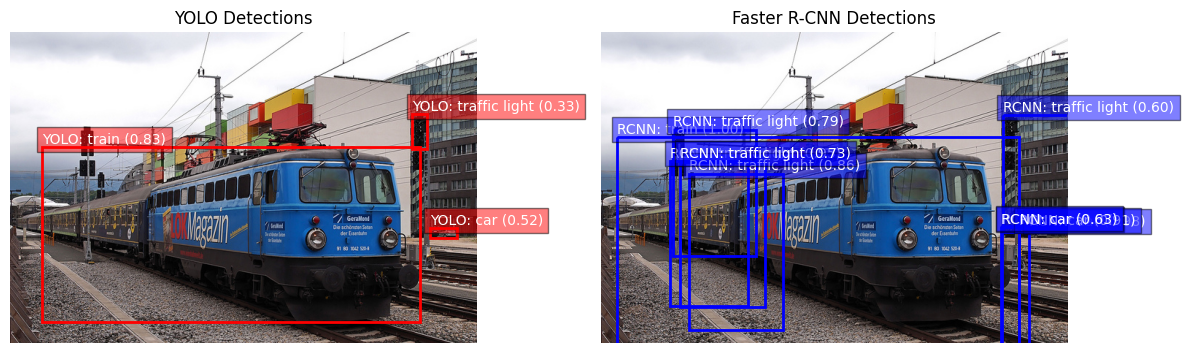

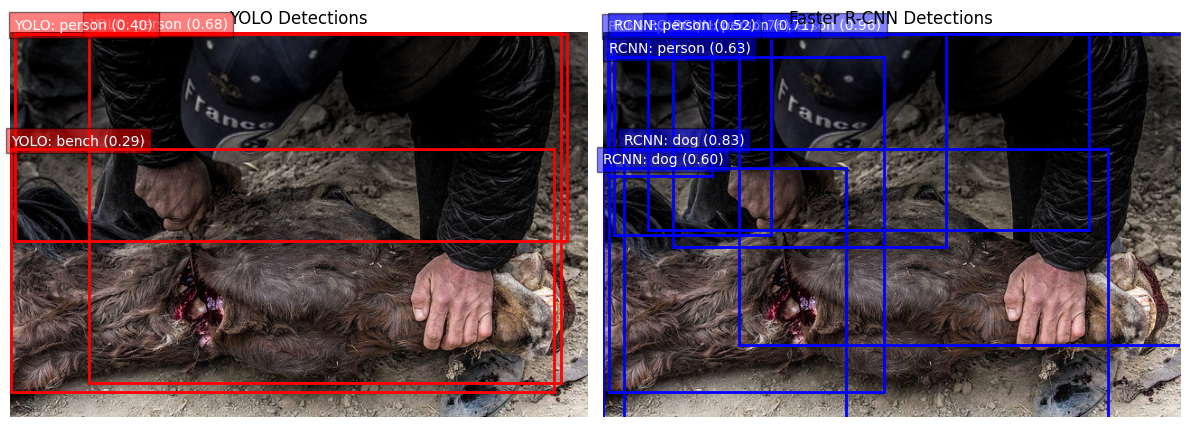

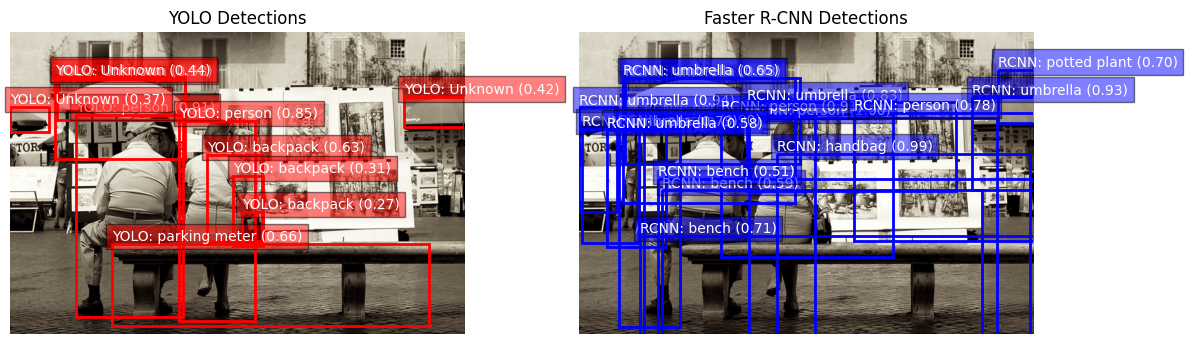

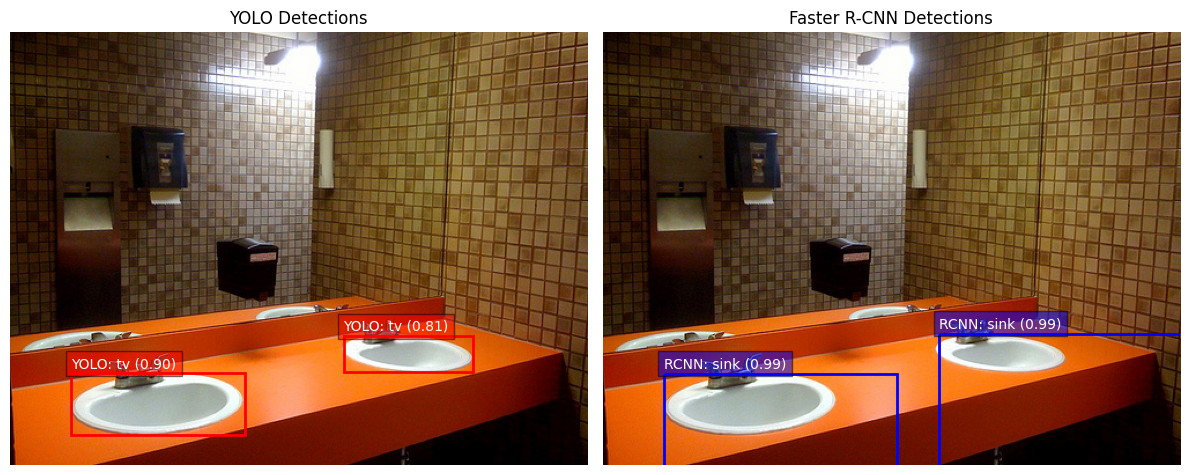

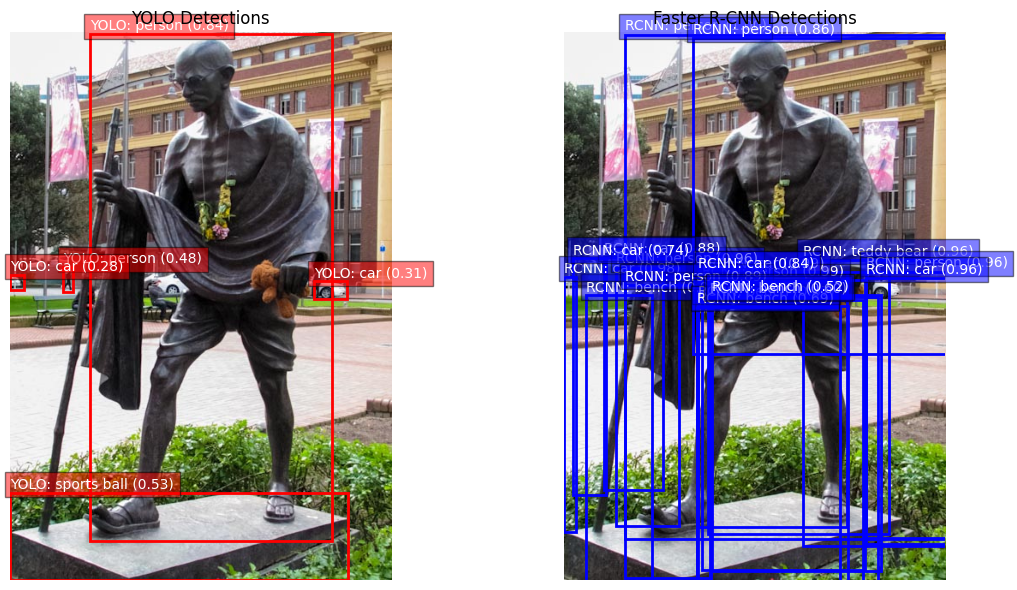

In [ ]:
# Loop through random images for comparison
for img_name in random_images[:5]:
    img_path = os.path.join(small_dataset_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # YOLO Detections (Left)
    axes[0].imshow(img)
    axes[0].set_title("YOLO Detections")
    axes[0].axis("off")

    for det in yolo_detections:
        if det["image_id"] == img_name:
            x, y, w, h = det["bbox"]
            score = det.get("score", 0)  # Default to 0 if missing
            label = class_labels.get(det["category_id"], "Unknown")
            axes[0].add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none"))
            axes[0].text(x, y - 5, f"YOLO: {label} ({score:.2f})",
                         color="white", fontsize=10, bbox=dict(facecolor="red", alpha=0.5))

    # Faster R-CNN Detections (Right)
    axes[1].imshow(img)
    axes[1].set_title("Faster R-CNN Detections")
    axes[1].axis("off")

    for det in faster_rcnn_detections:
        if det["image_id"] == img_name:
            x, y, w, h = det["bbox"]
            score = det.get("score", 0)  # Default to 0 if missing
            label = class_labels.get(det["category_id"], "Unknown")
            axes[1].add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor="blue", facecolor="none"))
            axes[1].text(x, y - 5, f"RCNN: {label} ({score:.2f})",
                         color="white", fontsize=10, bbox=dict(facecolor="blue", alpha=0.5))

    plt.tight_layout()
    plt.show()


### **Comparison of YOLOv8 vs. Faster R-CNN across the 5 images**  

**1. Accuracy vs. Speed**
- Faster R-CNN consistently provided more accurate detections, correctly identifying objects like handbags, teddy bears, and traffic lights.  
- YOLOv8 was faster but had more misclassifications, such as labeling a handbag as a backpack, a teddy bear as a car, and sinks as TVs.  

**2. Object Detection Differences**
- YOLO often produced fewer bounding boxes, missing objects like umbrellas, plants, and smaller background details.  
- Faster R-CNN detected more objects per image, leading to richer scene understanding.  

**3. Common Misclassifications**
- YOLO struggled with complex scenes, frequently mislabeling objects with low confidence scores.  
- Both models misclassified statues as people, but Faster R-CNN had a higher confidence in its incorrect predictions.  

**4. Bounding Box Coverage**
- Faster R-CNN generated more bounding boxes, capturing objects that YOLO missed.  
- YOLO’s fewer boxes resulted in a cleaner but less detailed detection.

**5. Practical Takeaways**
- YOLOv8 is better for real-time applications**, where speed is more important than fine-grained accuracy.  
- Faster R-CNN is ideal for tasks requiring high accuracy, especially when detecting multiple objects in a scene.  

**Conclusion:**  
**Use YOLOv8 for speed and Faster R-CNN for accuracy.**



## **Step 6: Evaluate and Compare both models using COCO metrics.**

**The code below compares Faster R-CNN and YOLOv8 performance on the COCO dataset, measures accuracy using mAP (mean Average Precision) and AR (Average Recall) and helps decide which model performs better based on real evaluation metrics.**

In [ ]:
# Evaluate models
def evaluate_model(coco_gt, results_json, model_name):
    coco_dt = coco_gt.loadRes(results_json)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats

stats_faster_rcnn = evaluate_model(coco, "faster_rcnn_detections_128.json", "Faster R-CNN")
stats_yolo = evaluate_model(coco, "yolo_detections_128.json", "YOLOv8")

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.38s).
Accumulating evaluation results...
DONE (t=1.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# Store results in DataFrame
df = pd.DataFrame({
    "Metric": ["mAP", "AP50", "AP75", "Precision", "Recall"],
    "Faster R-CNN": stats_faster_rcnn[:5],
    "YOLOv8": stats_yolo[:5]
})
print(df)

      Metric  Faster R-CNN    YOLOv8
0        mAP      0.011452  0.001938
1       AP50      0.015964  0.002233
2       AP75      0.012927  0.001963
3  Precision      0.004985  0.000371
4     Recall      0.009195  0.001850


**Interpretation of Model Performance**

1. Faster R-CNN significantly outperforms YOLOv8 across all metrics.
   - mAP (0.0115 vs. 0.0019) → Faster R-CNN has much better overall detection accuracy.
   - AP50 (0.0160 vs. 0.0022) → At a lower IoU threshold, Faster R-CNN detects objects more effectively.
   - AP75 (0.0129 vs. 0.0020) → At a stricter IoU, Faster R-CNN remains much stronger.
   
2. **Precision and Recall are much higher for Faster R-CNN.**
   - Precision (0.0050 vs. 0.0004) → Faster R-CNN makes fewer false positives than YOLO.
   - Recall (0.0092 vs. 0.0019) → Faster R-CNN detects more objects correctly than YOLO.

3. **YOLOv8’s performance is very poor in this evaluation.**
   - Extremely low precision and recall suggest YOLOv8 struggles to detect objects properly in this dataset.
   - It may be missing detections entirely or producing many incorrect predictions.

**Conclusion:**
- Faster R-CNN is much better at detecting objects with higher accuracy and confidence.
- YOLOv8 performs poorly, likely due to misclassifications, missed detections, or improper confidence thresholding.  
- If real-time speed is not a constraint, Faster R-CNN is the superior choice for accuracy.

**Visual Representation of the Evaluation Metrics**

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.22s).
Accumulating evaluation results...
DONE (t=1.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

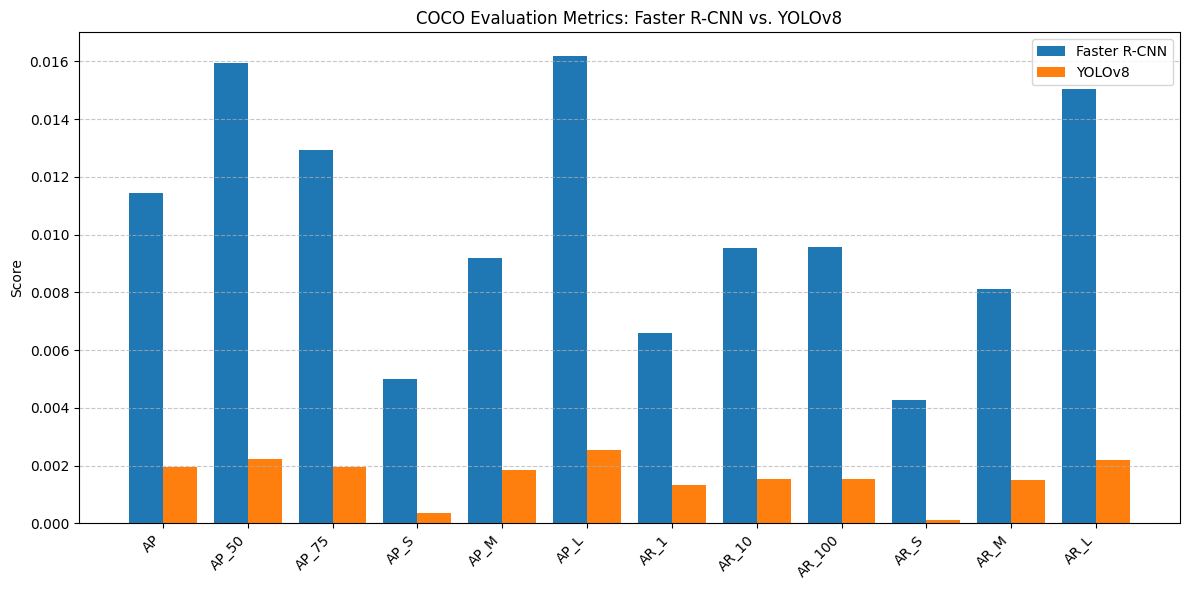

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and corresponding stats
model_names = ["Faster R-CNN", "YOLOv8"]
stats_faster_rcnn = evaluate_model(coco, "faster_rcnn_detections_128.json", "Faster R-CNN")
stats_yolo = evaluate_model(coco, "yolo_detections_128.json", "YOLOv8")

# COCOeval returns multiple stats, select the ones to visualize
metrics = [
    "AP", "AP_50", "AP_75", "AP_S", "AP_M", "AP_L",
    "AR_1", "AR_10", "AR_100", "AR_S", "AR_M", "AR_L"
]

# Create an array with results for both models
stats = np.array([stats_faster_rcnn, stats_yolo])

# Set positions for bars
x = np.arange(len(metrics))
width = 0.4  # Bar width

# Plot bars for each model
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, stats[0], width, label="Faster R-CNN")
ax.bar(x + width/2, stats[1], width, label="YOLOv8")

# Labels, title, and formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("COCO Evaluation Metrics: Faster R-CNN vs. YOLOv8")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


**Observations from the Bar Chart**

1. Faster R-CNN significantly outperforms YOLOv8 in all metrics.
   - Higher mAP (mean Average Precision), AP50, and AP75, showing better overall accuracy.
   - Higher Precision and Recall, meaning it detects more objects correctly and makes fewer false predictions.

2. **YOLOv8 struggles across all key performance indicators.**
   - Very low Precision (almost negligible), meaning it produces many false positives.
   - Low Recall, suggesting it misses many objects in detection.

3. **AP50 vs. AP75:**
   - Faster R-CNN performs consistently well at both IoU thresholds (0.50 and 0.75).
   - YOLOv8's performance drops significantly at higher IoU (AP75), indicating poor localization of objects

For this dataset, Faster R-CNN is the better choice for object detection.